In [1]:
import torch
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

%load_ext autoreload

%autoreload 2


In [7]:
# prepare the dataset

from os.path import splitext
from os import listdir
import logging
from torch.utils.data import DataLoader, random_split
from masks import BasicDataset
dir_img = 'other_data/crop_imgs/'
dir_mask = 'other_data/crop_masks/'

batch_size = 2
val_percent = 0.2

dataset = BasicDataset(dir_img, dir_mask, size=256)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val

train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=False)

In [8]:
print(len(train_loader))
print(len(val_loader))

80
20


In [9]:
from tqdm import tqdm

def generate_example(model, loader):
    model.eval()

    rand_index = random.randrange(len(loader.dataset))
    image, mask = loader.dataset[rand_index]
    
    device = model.device
    image  = image.to(device) 
    
    
    with torch.no_grad():
        reconstructed_image = model.generate(image.unsqueeze(0)).squeeze(0)

    
    image = ((image.permute(1, 2, 0) + 1) / 2).cpu().numpy()
    mask = ((mask.permute(1, 2, 0) + 1) / 2).cpu().numpy()
    reconstructed_image = ((reconstructed_image.permute(1, 2, 0) + 1) / 2).cpu().numpy()

    # example = {'input image': wandb.Image(image),
    #            'reconstructed image': wandb.Image(reconstructed_image),
    #            }
    
    return image, reconstructed_image, mask

def train(epoch, loader, model, n_disc=1):
    d_losses = []
    g_losses = []
    model.train()
    device = model.device
    for i, (image, mask) in tqdm(enumerate(loader), desc=f"trainloop: {epoch}", leave=False):
        image, mask = image.to(device), mask.to(device)

        d_loss = model.trainD(image, mask)
        g_loss = model.trainG(image, mask)
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (i + 1) % 150 == 0:
            example = generate_example(model, loader)
            g_train_loss = np.mean(g_losses)
            d_train_loss = np.mean(d_losses)
            d_losses = []
            g_losses = []
                    
            example.update({'G loss': g_train_loss,
                            'D loss': d_train_loss
                            })

            # wandb.log(example)
            print('G_loss:', g_train_loss, 'D_loss:', d_train_loss)
            model.train()
            torch.save(model.G.state_dict(), PATH + name + "_generator.pt")
            torch.save(model.D.state_dict(), PATH + name + "_critic.pt")
            

In [10]:
from model import StarGAN

device = torch.device('cuda:1')

model = StarGAN(device, d_n_layers=2, g_n_layers=2, c_dim=1, image_size=256)

In [ ]:
epochs = 300
for i in range(1, epochs + 1):
    train(i, train_loader, model)

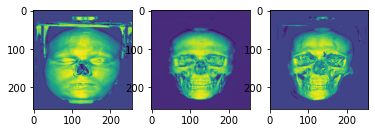

In [ ]:
im, gen, mask = generate_example(model, val_loader)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(im)
ax[1].imshow(gen)
ax[2].imshow(mask)